In [0]:
def super_resolution(img, sr_factor, model=None):
    """Super Resolve an image

    Args:
        img (numpy array): Input image
        sr_factor (int): Factor by which resolution should increase
        model (tf model): Trained ML model for SR
    Returns:
        sr_img (numpy array): Super Resolved image
    """
    if model is None:
        res = cv2.resize(img, None, fx=sr_factor, fy=sr_factor, interpolation=cv2.INTER_CUBIC)
        return res
    
    img = img.astype(np.float32)
    interpolated_image = cv2.resize(img, None, fx=sr_factor, fy=sr_factor, interpolation=cv2.INTER_CUBIC)
    interpolated_image = np.expand_dims(interpolated_image, axis=0)
    
    sr_img = model.predict(interpolated_image)
    sr_img = np.squeeze(sr_img, axis=(0))
    sr_img = cv2.convertScaleAbs(sr_img)

    return sr_img

In [0]:
SR_FACTOR = 2

 # Mean pixel noise added to lr sons
INITIAL_LRATE = 0.001 # INITIAL Learning rat
CV_IMWRITE_PNG_COMPRESSION = 9 # png compression ratio: best quality
LEARNING_RATE_CYCLES = False # Decide if learning rate should drop in cyclic periods.

In [7]:
import cv2
import numpy as np

name = 'letters'

cap = cv2.VideoCapture('/content/' + name + '.mp4')
if (cap.isOpened()== False): 
    print("Error opening video stream or file")

w = int(cap.get(3))
h = int(cap.get(4))
fps = cap.get(cv2.CAP_PROP_FPS)

frame_array=[]
size = (w,h)

path_out = 'lr_' + name + '.avi'
out = cv2.VideoWriter(path_out, cv2.VideoWriter_fourcc(*'DIVX'), fps, size)
while cap.isOpened():
    ret, img = cap.read()
    if ret == True:
        out.write(img)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        frame_array.append(img)
    else:
        out.release()
        break

frame_array = np.array(frame_array)
lr_array = frame_array.copy()
frame_array.shape

(99, 320, 240, 3)

In [33]:
from data import DatasetLoader
from utils import *
from network import ZSSR

import time
import math
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

SR_FACTOR = 2 # scaling factor
EPOCHS = 21000
NB_PAIRS = math.ceil(EPOCHS / frame_array.shape[0])# NB pais 
NB_STEPS = 1 # Steps per epoch

NB_CHANNELS = 3 #Channels
FILTERS = 64 # FILTERS

CROP_SIZE = [96] # image crop size
NOISE_FLAG = True
NOISY_PIXELS_STD = 0.04


dl = DatasetLoader((frame_array.shape[1], frame_array.shape[2],
                 frame_array.shape[3]),
                )
s_fact, inter_s_fact = dl.s_fact(SR_FACTOR, NB_PAIRS, NB_STEPS)


zssr = ZSSR(NB_CHANNELS, FILTERS)
optimizer = tf.keras.optimizers.Adam(learning_rate=INITIAL_LRATE)

def loss(model, x, y, training):
  y_ = model(x, training=training)
  mse = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM)
  psnr = tf.image.psnr(y, y_, max_val = 255)
  return mse(tf.reshape(y, [-1]), tf.reshape(y_, [-1])), psnr
def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value, psnr_value = loss(model, inputs, targets, training=True)
  return loss_value, psnr_value, tape.gradient(loss_value, model.trainable_variables)

loss_avg = []
psnr_avg = []

st = time.time()

pbar = tqdm(total=NB_PAIRS)
for i, (sf, isf) in enumerate(zip(s_fact, inter_s_fact)):
    loss_ = 0
    psnr_ = 0
    for frame in frame_array:
        X, y = preprocess(frame, sf, isf, CROP_SIZE,
                          NOISE_FLAG, NOISY_PIXELS_STD)
        ''' Train zssr '''
        # plt.figure()
        # plt.imshow(X[0,:,:,:].astype(np.uint8))
        # break
        loss_value, psnr_value, grads = grad(zssr, X, y)
        optimizer.apply_gradients(zip(grads, zssr.trainable_variables))
        
        loss_ += loss_value.numpy()
        psnr_ += psnr_value.numpy()[0]

    loss_avg.append(loss_ / len(frame_array)) 
    psnr_avg.append(psnr_ / len(frame_array))

    pbar.update(1)
    pbar.set_postfix_str("e: {}/{} => Loss: {:.3f}, Psnr: {:.3f}". format(
            i, NB_PAIRS, loss_ / len(frame_array), psnr_ / len(frame_array)))
et = time.time()
print("Number of Pairs:", NB_PAIRS)
print("Time spent: ", time_diff(et, st))

Number of Pairs: 213
Time spent:  (8, 27)


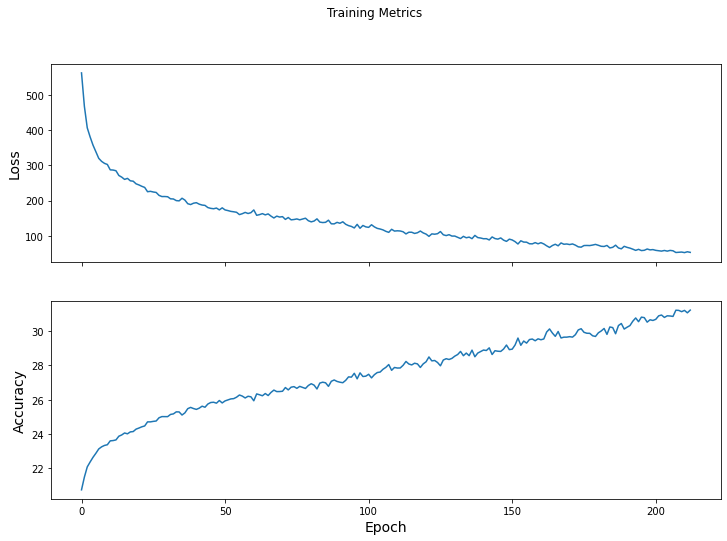

In [34]:
 fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(loss_avg)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(psnr_avg)
plt.show()

# Assemble Video

## ZSSR

In [35]:
st = time.time()

path_out = 'zssr_' + name + '_e' + str(EPOCHS) +'.avi'
out_size = (lr_array[0].shape[1] * SR_FACTOR, lr_array[0].shape[0] * SR_FACTOR)
out = cv2.VideoWriter(path_out, cv2.VideoWriter_fourcc(*'DIVX'), fps, out_size)

for lr in lr_array:
    sr = super_resolution(lr, SR_FACTOR, model=zssr)
    sr = cv2.cvtColor(sr, cv2.COLOR_BGR2RGB)
    out.write(sr)
out.release()

et = time.time()
print("Save time spent: ", time_diff(et, st))

Save time spent:  (0, 5)


## Bicubic

In [0]:
path_out = 'bicubic_' + name +'.avi'
out_size = (lr_array[0].shape[1] * SR_FACTOR, lr_array[0].shape[0] * SR_FACTOR)
out = cv2.VideoWriter(path_out, cv2.VideoWriter_fourcc(*'DIVX'), fps, out_size)

for lr in lr_array:
    sr = super_resolution(lr, SR_FACTOR)
    sr = cv2.cvtColor(sr, cv2.COLOR_BGR2RGB)
    out.write(sr)
out.release()